# Notebook de la práctica 3 de **FAA**.

**Javier López Cano y Gonzalo Madrigal.** Grupo 1462.

In [1]:
# -*- coding: utf-8 -*-

# coding: utf-8
from Datos import Datos
import numpy as np
from Clasificador import Clasificador, ClasificadorNaiveBayes, ClasificadorGenetico
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import matplotlib.pyplot as	plt


Función para representar gráficamente los valores para la **curva ROC**.

In [2]:

def valores_roc(data, pred):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    for i in range(0, len(pred)):
        if pred[i] == data[i]:
            if pred[i] == 1:
                tp += 1
            elif pred[i] == 0:
                tn += 1
        elif pred[i] != data[i]:
            if pred[i] == 1:
                fp += 1
            elif pred[i] == 0:
                fn += 1
    return tp, tn, fp, fn


Procesamos el dataset *Titanic* para trabajar con él

In [3]:

    titanic = Datos("titanic.data", allNominal=True)

    print("Titanic:\n")
    print("nominalAtributos:")
    print(titanic.nominalAtributos)
    print("\nDiccionario:")
    print(titanic.diccionario)
    print("\nDatos:")
    print(titanic.datos)




Titanic:

nominalAtributos:
[True, True, True, True]

Diccionario:
{'Pclass': {'1': 0, '2': 1, '3': 2}, 'Sex': {'female': 0, 'male': 1}, 'Age': {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15}, 'Class': {'0': 0, '1': 1}}

Datos:
[[ 1  1  9  1]
 [ 1  1 12  1]
 [ 2  0 10  0]
 ...
 [ 2  0 10  1]
 [ 2  1 10  0]
 [ 1  1  9  0]]


En esta última práctica de FAA hemos implementado un **algoritmo genético**. Estos métodos emulan el funcionamiento de la evolución biológica. Se somete a una población de individuos a una serie de acciones aleatorias (**mutaciones** y **recombinaciones**) y a un proceso de selección, que en este caso llevará a cabo la **función de fitness**, para que solo "sobrevivan" los individuos mejor adaptados y sus descendientes. Al cabo de una serie de generaciones, los individuos de nuestra población estarán mejor adaptados al problema que queremos solucionar que los originales.


La opción utilizada en esta práctica para la aproximación del cromosoma es el enfoque de $\textit{Pittsburg}$, haciendo que cada individuo represente un conjunto de reglas. El número de estas reglas será variable en función de lo que indiquemos al crear el clasificador. 

Para generar la población incial se ha establecido un parámetro "max" que determina el número máximo de reglas que un individuo puede tener en esta población inicial (aunque con los cruces puede superarse). Generamos un número al azar entre 1 y este valor, para determinar el número de reglas del individuo a crear, y, a partir del diccionario de sustitución del dataset determinamos el número de bits necesarios para codificar una regla (1 para cada valor posible de cada atributo, más 1 para la clase), y generamos una string aleatoria de 1s y 0s de longitud = número de reglas * tamaño de regla, y repetimos el proceso hasta generar todos los individuos de la población.

A continuación dejamos comentado el código utilizado para llegar a la conclusión de que la mejor opción es tamaño de regla = 10 y ambas probabilidades = 1. Esto es así porque al pasar a la siguiente generación el mejor 5% de los individuos, nunca perderemos a los mejores por muchas mutaciones y recombinaciones que hagamos, por tanto unas probabilidades altas no suponen problema, y, además, generan mayor variedad entre los individuos de la población, dando mayores probabilidades de encontrar un mejor individuo. El número de reglas es de nuevo cuanto mayor, mejor, ya que un número de reglas alto permite mayor variación en la longitud de reglas de los individuos (de 1 al número seleccionado) generando de nuevo mayor variedad en los individuos)
A pesar de que estos sean los valores óptimos, no son los que hemos empleado para las pruebas posteriores, puesto que suponen costes de tiempo muy elevados, especialmente el número máximo de reglas; por tanto, hemos empleado valores bastante inferiores.

In [4]:
 ##################################################################################################################
    # HALLAR MEJORES PROBABILIDADES Y TAMAÑO DE REGLA (NO EJECUTAR, sale tamaño de regla 10, y ambas probs 1)
    #args = {"epocas": 100, "pob_size": 50, "max": 3, "prob_cruce": 0.5, "prob_mutacion": 0.1, "plot": False}
    #best_err = 1
    #best_args = {}
    #for max_reg in range(1, 11):
    #    args["max"] = max_reg
    #    gen = ClasificadorGenetico()
    #    vs = ValidacionSimple()
    #    error = Clasificador.validacion(vs, titanic, gen, args=args)
    #    if error[0] < best_err:
    #        best_err = error[0]
    #        best_args = args

    #args["max"] = best_args["max"]

    #best_err = 1
    #best_args = {}
    #for prob_cruce in np.arange(0, 1, 0.05):
    #    args["prob_cruce"] = prob_cruce
    #    gen = ClasificadorGenetico()
    #    vs = ValidacionSimple()
    #    error = Clasificador.validacion(vs, titanic, gen, args=args)
    #    if error[0] < best_err:
    #        best_err = error[0]
    #        best_args = args

    #args["prob_cruce"] = best_args["prob_cruce"]
    
    #for prob_mutacion in np.arange(0, 1, 0.05):
    #    args["prob_mutacion"] = prob_mutacion
    #    gen = ClasificadorGenetico()
    #    vs = ValidacionSimple()
    #    error = Clasificador.validacion(vs, titanic, gen, args=args)
    #    # print("Error medio " + str(error[0]))
    #    if error[0] < best_err:
    #        best_err = error[0]
    #        best_args = args

    #print(str(best_args))

    ###################################################################################################################

El **mecanismo de cruce** que hemos elegido una aproximación del **cruce en un punto**. No se trata exactamente de una cruce en un punto típico porque queríamos permitir que variase el número de reglas de los hijos con respecto a los padres. Para ello, escogemos un punto aleatorio del primer padre, y en vez de escoger el mismo punto del segundo padre, escogemos otro punto aleatorio, pero que cumpla la condición de estar en la misma posición dentro de una de las reglas. De este modo, si las reglas son de tamaño 10, y obtenemos como posición en el padre 1 12, este corte se realizará en la posición 2 de la segunda regla, por tanto para el segundo padre generamos un número aleatorio entre 0 y su número de reglas -1 (x), y seleccionamos como punto de corte en el segundo padre el valor 10x+2.A partir de este algoritmo simulamos una aproximación "de nuevo no exacta" del cruce en 2 y 3 puntos, símplemente mediante la ejecución de este algoritmo varias veces. 

Para llevar a cabo el cruce, seleccionamos a los padres (de forma proporcional al fitness y una vez los tenemos, si se cumple la **probabilidad de cruce**, seleccionamos de forma aleatoria si los cruzamos en 1, 2 o 3 puntos, y de este modo damos lugar a los hijos.

La **probabilidad de cruce** es un parámetro esencial para un algoritmo genético, ya que un número excesivo de cruces por ronda puede homogeneizar los individuos demasiado rápido, haciendo que el algoritmo converja antes de tiempo. En nuestro caso esto no sucede tán rápido debido a que el algoritmo de cruce implementado permite variación en el tamaño de reglas, generando variedad incluso con los cruces, por lo que estos homogeinizan la población a un ritmo más lento. Una probabilidad de cruce muy alta puede también suponer la pérdida de los mejores individuos, si estos no están protegidos por una selección elitista, pero en nuestro caso se produce este tipo de selección, por lo que esto no sucede. Por el contrario una probabilidad de cruce muy baja ralentiza enormemente el algoritmo, pues hay una variación menor de la población, y el algoritmo se estabiliza y converge mucho más tarde, por lo que se necesitan muchas más épocas.

En el caso de la **mutación**, consiste simplemnete en cambiar un bit si se cumple la probabilidad. Una probabilidad de mutación muy baja puede llevarnos al fenómeno de **deriva genética**, y una muy alta (aunque no en este caso, debido a la selección elitista) podría hacer que perdiéramos los mejores individuos por mutarlos.

El número máximo de reglas en la población inicial es también de gran importancia pues afecta notablemente a la variedad de los individuos de esta. Una mayor diversidad en la población supone que este tardará más rondas en converger, pero si se le dan suficientes épocas tiene una mayor probabilidad de hallar un individuo óptimo. Sin embargo, este parámetro tambien aumenta en gran medida el tiempo de ejecución del algoritmo.

Por último, otros parámetros de gran importancia son el tamaño de la población y el número de generaciones, muy relacionados entre sí. Cuanto mayor sea el tamaño de la población, también aumenta la diversidad de esta, dando lugar a una mayor probabilidad de hallar buenos individuos, sin embargo también aumenta el tiempo que tarda el algoritmo en converger (de forma similar a lo que ocurre con el número máximo de reglas). Esto provoca que sea también de gran importancia el número de generaciones, que determina si el algoritmo tendrá o no el las roondas necesarias como para converger y hallar un individuo óptimo. Estos parámetros se deben escoger con cuidado, ya que, aunque a priori parece que cuanto más grandes sean estos valores, mejor será la ejecución del algoritmo, se debe tener en cuenta que suponen un aumento grande de coste, y que a partir de ciertos valores, la mejora será mínima, haciendo que no merezca la pena la ligera mejora por un coste temporal muy elevado.

Para la **clasificación**, el mecanismo que hemos utilizado consiste en evaluar las reglas del mejor individuo sobre el conjunto de datos de entrenamiento. Para cada regla evaluada obtenemos una clase (0 o 1), y para clasificar tomamos la clase más repetida, o, en caso de empate, escogemos la clase 1.
La **función de fitness** es una parte crítica de un algoritmo genético, ya que es aquí donde se va a dar la selección de los mejores individuos. Siempre se debe tener en cuenta el coste computacional ya que se va a repetir su ejecución de forma prácticamente ininterrumpida; sin embargo debe ser lo suficientemente precisa para detectar los mejores individuos en cada iteración.



Titanic:

Validación Simple, Población 50, 100 épocas


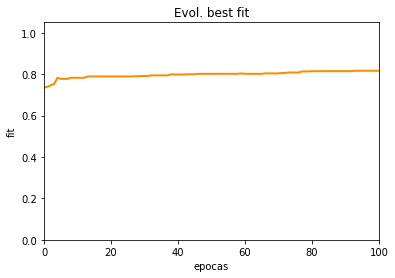

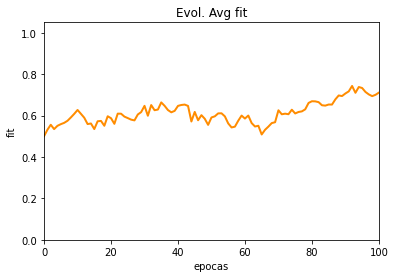

Mejor conjunto de reglas:
00000100011000111101001111010101010011110000001111011101101111000100111111111001111011110000010000100011111010000001001101001110111100111011111010111100010111010111100111111010000001011110101111111000101011000000111111110100010111010011101111001110111110011111110111001001111000111111110000010101010011110000000001011110011110101100110101111001111110100000011111100011111111000001000110101111000011110100010010100101101010101111011011101111001110111110011111110111001001111000111111110000010101010011110000001111111110011111111100000100011000111101001111010001001110010110
Error en partición 0[0.25961538461538464]

Error medio: 0.25961538461538464


Validación Simple, Población 50, 200 épocas


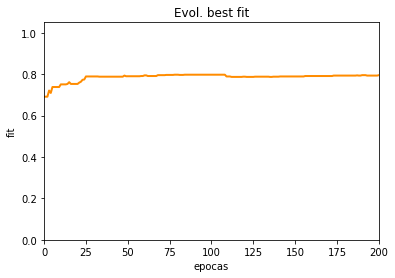

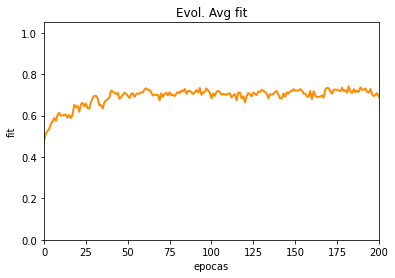

Mejor conjunto de reglas:
1001001111111101001011111101011110111100111000000111111011101100001000011111011110100011110100111110101100111000000111111011100100001000011011011111011111110110111100101010101011000111110001010010111111011111001101111000111100111111100010010111010100010111010010001101011111001011111110
Error en partición 0[0.22115384615384615]

Error medio: 0.22115384615384615


Validación Simple, Población 150, 100 épocas


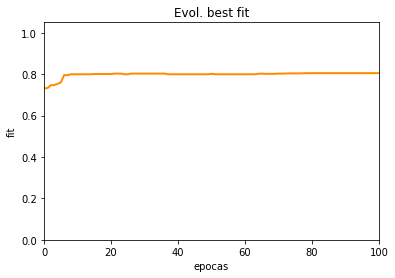

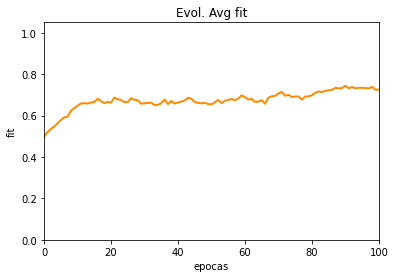

Mejor conjunto de reglas:
11101001001011010111001101001100101100110010010101000010111001000111110100110001011000000100010101101100010001111101011000110001110011010011101001001101001101001110100111111110110100111010000010010111110110110001111100100100010100100100000101010101010010000011000101110000001111010111001101001110101100110010010111010000111001000101000101010011110011001101010110001100000000110100111010010011000101110000011001001111011111010110001000110100110100111010010011010011010011101001111111100100110100100000110101011110101110011101110011110110110000010100100101010011001110100101111101101100011100111011010101100001001001011111011011000111001110110111011000011101110011010011101001001100100111010011000100100000010011010010000011010101111000011011000100011111010111001000010000110100111001101001000110000101001001111100101100010100100100000101010101001110011101110011000111001011100000011111010001000101100010110000000110110001000011010011100001001101001101001110100111110010010001

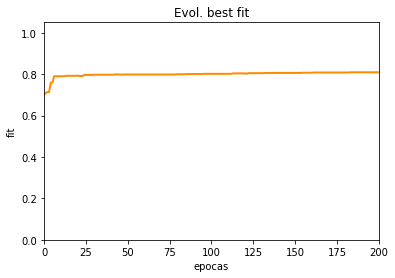

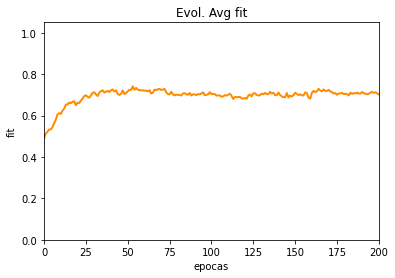

Mejor conjunto de reglas:
10001110010100110110001010111000010100011101110100110010011101011010001110110100000111011001011010001001101000100101010001010001010111010011011000110111101000110010011101001111010001100101010101111000001110110111000111111011011101010101011110010101110100010110000011001010010001110011111010111001000100011101110101010101111100111011110100110001011000000101000101010111000000100011100101010100110111001110010101010010000100111001000100110100
Error en partición 0[0.20192307692307693]

Error medio: 0.20192307692307693



In [5]:
    args = {"epocas": 100, "pob_size": 50, "max": 3, "prob_cruce": 0.7, "prob_mutacion": 0.5, "plot": True}
    print("\n\nTitanic:")
    print("\nValidación Simple, Población 50, 100 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, titanic, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")

    args["epocas"] = 200
    print("\nValidación Simple, Población 50, 200 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, titanic, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")

    args["epocas"] = 100
    args["pob_size"] = 150
    print("\nValidación Simple, Población 150, 100 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, titanic, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")

    args["epocas"] = 200
    print("\nValidación Simple, Población 150, 200 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, titanic, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")

Como podemos observar, los resultados se dan conforme a lo esperado. Cuanto mayor es la población sobre la que trabajamos, más "adaptado" estará el mejor individuo que encontremos. Además, cuantas más generaciones dejemos trabajar a nuestro método mejores resultados se obtienen. Estos dos parámetros sin embargo generan cada vez una mejoría menor y un aumento de tiempo de ejecución mayor, por lo que hay que encontrar siempre un término medio acorde a las necesidades del problema a resolver.
Se puede observar también, gracias a la selección elitista, que el mejor individuo no empeora nunca, sino que o mejora o se mantiene constante.

A la vista de los resultados podemos afirmar que el mejor par de valores para las épocas y tamaño de población es 150-200.

Si observamos el mejor individuo que nos indica el programa, vemos una hilera de 1s y 0s dificil de entender, pero si tenemos en cuenta que estos representan reglas, y que, en este caso de titanic, estas reglas son de tamaño 22 bits (debido al número de argumentos y valores que estos pueden tomar), podemos analizarlas en profundidad. Tomemos por ejemplo el mejor individuo del caso 150-200:

10001110010100110110001010111000010100011101110100110010011101011010001110110100000111011001011010001001101000100101010001010001010111010011011000110111101000110010011101001111010001100101010101111000001110110111000111111011011101010101011110010101110100010110000011001010010001110011111010111001000100011101110101010101111100111011110100110001011000000101000101010111000000100011100101010100110111001110010101010010000100111001000100110100

Cada 22 bits representan una determinada regla, por tanto analizamos los primeros 22 bits:

1000111001010011011000

Sabemos que los datos tienen 3 argumentos, el primero toma 3 posibles valores (del 1 al 3) y por tanto es representado por 3 bits, el segundo toma 2 valores (2 bits), y el tercero 16 valores (16 bits), el último bit corresponde a la clase predicha por la regla:

100 01 1100101001101100 0

Esta regla nos indica por tanto:
Si el primer argumento es el codificado como 0 (1), y el segundo es el codificado como 1 (), y el tercero es uno de los codificados como 0, 1, 4, 6, 9, 10, 12 o 13, el dato es de clase 0, en caso contrario es de clase 1.

Teniendo en cuenta que la clase Datos codifica los atributos de 0 en adelante yendo de menor a mayor (y teniendo en cuenta que son strings y por tanto 10 < 2), esta regla indica:

Si Pclass es 1, Sex es male y Age es 0, 1, 12, 14, 3, 4, 6 o 7, entonces es de clase 0, en caso contrario es de clase 1. 

A continuación realizamos el **análisis ROC** de nuestro algoritmo genético con diferentes parámetros y lo comparamos con **Naive-Bayes**.

In [6]:
    # Análisis ROC
    args = {"epocas": 100, "pob_size": 50, "max": 3, "prob_cruce": 0.7, "prob_mutacion": 0.5, "plot": False}
    print("50-100")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(titanic.datos)
    particiones = vs.particiones
    gen.entrenamiento(titanic.extraeDatos(particiones[0].indicesTrain), titanic.nominalAtributos, titanic.diccionario, args)
    datosTest = titanic.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, titanic.nominalAtributos, titanic.diccionario)
    clase = datosTest[:, len(titanic.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_50_100 = fpr
    Y_50_100 = tpr

50-100


In [7]:
    args["pob_size"] = 150
    print("150-100")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(titanic.datos)
    particiones = vs.particiones
    gen.entrenamiento(titanic.extraeDatos(particiones[0].indicesTrain), titanic.nominalAtributos, titanic.diccionario,
                      args)  
    datosTest = titanic.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, titanic.nominalAtributos, titanic.diccionario)
    clase = datosTest[:, len(titanic.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_150_100 = fpr
    Y_150_100 = tpr



150-100


In [8]:

    args["pob_size"] = 50
    args["epocas"] = 200
    print("50-200")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(titanic.datos)
    particiones = vs.particiones
    gen.entrenamiento(titanic.extraeDatos(particiones[0].indicesTrain), titanic.nominalAtributos, titanic.diccionario,
                      args)
    datosTest = titanic.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, titanic.nominalAtributos, titanic.diccionario)
    clase = datosTest[:, len(titanic.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_50_200 = fpr
    Y_50_200 = tpr


50-200


In [9]:
    args["pob_size"] = 150
    print("150-200")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(titanic.datos)
    particiones = vs.particiones
    gen.entrenamiento(titanic.extraeDatos(particiones[0].indicesTrain), titanic.nominalAtributos, titanic.diccionario,
                      args)
    datosTest = titanic.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, titanic.nominalAtributos, titanic.diccionario)
    clase = datosTest[:, len(titanic.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_150_200 = fpr
    Y_150_200 = tpr

150-200


In [10]:
    print("NB")
    nb = ClasificadorNaiveBayes()
    vs = ValidacionSimple()
    vs.creaParticiones(titanic.datos)
    particiones = vs.particiones
    nb.entrenamiento(titanic.extraeDatos(particiones[0].indicesTrain), titanic.nominalAtributos, titanic.diccionario)
    datosTest = titanic.extraeDatos(particiones[0].indicesTest)
    result = nb.clasifica(datosTest, titanic.nominalAtributos, titanic.diccionario)
    clase = datosTest[:, len(titanic.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_nb = fpr
    Y_nb = tpr

NB


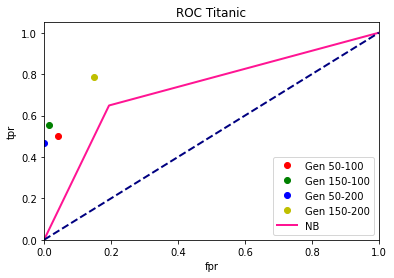

In [11]:
    plt.figure()
    lw = 2
    plt.plot(X_50_100, Y_50_100, "ro", lw=lw, label="Gen 50-100")
    plt.plot(X_150_100, Y_150_100, "go", lw=lw, label="Gen 150-100")
    plt.plot(X_50_200, Y_50_200, "bo", lw=lw, label="Gen 50-200")
    plt.plot(X_150_200, Y_150_200, "yo", lw=lw, label="Gen 150-200")
    plt.plot([0, X_nb, 1], [0, Y_nb, 1], color="deeppink", lw=lw, label="NB")
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Titanic")
    plt.legend(loc="lower right")
    plt.show()


Como podemos observar el algoritmo genético se encuentra por encima de la curva ROC correspondiente a Naive-Bayes en todas las mediciones que hemos realizado, mejorando a medida que aumentamos el tamaño de la población y el número de generaciones.

Por tanto se ve, de nuevo, que el los mejores valores de población y épocas son 150-200.

In [12]:
    tictac = Datos("tic-tac-toe.data", allNominal=True)

    print("Tic-tac-toe:\n")
    print("nominalAtributos:")
    print(tictac.nominalAtributos)
    print("\nDiccionario:")
    print(tictac.diccionario)
    print("\nDatos:")
    print(tictac.datos)

Tic-tac-toe:

nominalAtributos:
[True, True, True, True, True, True, True, True, True, True]

Diccionario:
{'TLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'TMidSq': {'b': 0, 'o': 1, 'x': 2}, 'TRightSq': {'b': 0, 'o': 1, 'x': 2}, 'MLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'MMidSq': {'b': 0, 'o': 1, 'x': 2}, 'MRightSq': {'b': 0, 'o': 1, 'x': 2}, 'BLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'BMidSq': {'b': 0, 'o': 1, 'x': 2}, 'BRightSq': {'b': 0, 'o': 1, 'x': 2}, 'Class': {'negative': 0, 'positive': 1}}

Datos:
[[2 2 2 ... 1 1 1]
 [2 2 2 ... 2 1 1]
 [2 2 2 ... 1 2 1]
 ...
 [1 2 1 ... 1 2 0]
 [1 2 1 ... 1 2 0]
 [1 1 2 ... 2 2 0]]




Tic-tac-toe:

Validación Simple, Población 50, 100 épocas


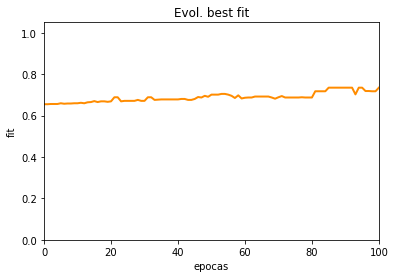

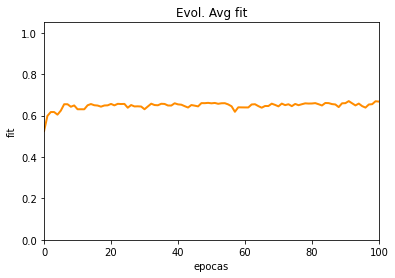

Mejor conjunto de reglas:
1101011111111101111111111101
Error en partición 0[0.29473684210526313]

Error medio: 0.29473684210526313



In [13]:
    # Representamos la evolución del best fit (usamos probabilidades y tamaño de regla mucho más bajas para reducir tiempo de ejecución)
    args = {"epocas": 100, "pob_size": 50, "max": 3, "prob_cruce": 0.7, "prob_mutacion": 0.5, "plot": True}
    print("\n\nTic-tac-toe:")
    print("\nValidación Simple, Población 50, 100 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, tictac, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")


Validación Simple, Población 50, 200 épocas


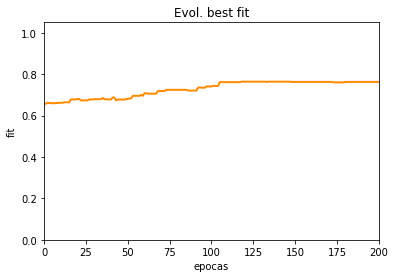

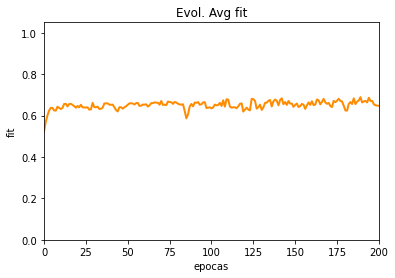

Mejor conjunto de reglas:
110011111100110111100101010111011111111111011111111111010100101111111001101111010100100000111101110111100110101011011011111110011001000111001101111110011101110011101011
Error en partición 0[0.2631578947368421]

Error medio: 0.2631578947368421



In [14]:

    args["epocas"] = 200
    print("\nValidación Simple, Población 50, 200 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, tictac, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")


Validación Simple, Población 150, 100 épocas


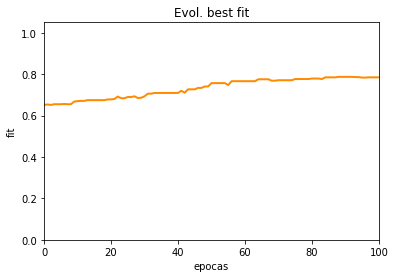

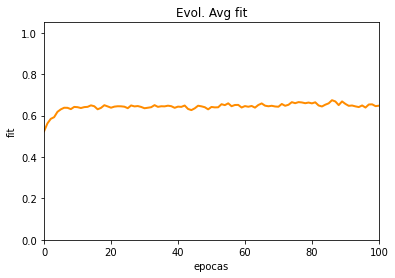

Mejor conjunto de reglas:
11111111110111011111001101111001111100111000101100111110111101111111010011110001101110011111011110000011011111010100011111100001110100001110111011111101100001010010111011011111111111011111001101110001111101111000001101111101010001111110000111010000111011101111111110000111101011101101111111111101111111111101
Error en partición 0[0.23157894736842105]

Error medio: 0.23157894736842105



In [15]:
    args["epocas"] = 100
    args["pob_size"] = 150
    print("\nValidación Simple, Población 150, 100 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, tictac, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")


Validación Simple, Población 150, 200 épocas


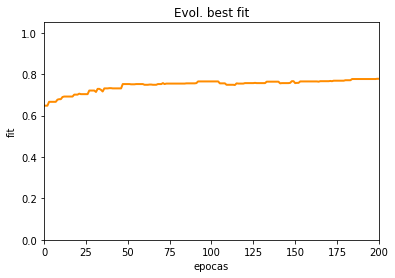

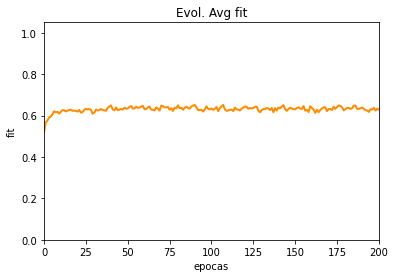

Mejor conjunto de reglas:
11111111011111011111011111110101111110101111110101111111010111110010011101001110111101010000001011111110010000100001011101110101011100010100
Error en partición 0[0.16842105263157894]

Error medio: 0.16842105263157894



In [16]:
    args["epocas"] = 200
    print("\nValidación Simple, Población 150, 200 épocas")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    error = Clasificador.validacion(vs, tictac, gen, args=args)
    print("\nError medio: " + str(error[0]) + "\n")

Como en el caso anterior, a mayor número de generaciones y tamaño de población mejor funciona nuestro algoritmo.Y, además, sigue cumpliendose que el mejor individuo nunca emperoa, como era de esperar. Sin embargo se observa una mejora más brusca del fit medio al inicio, que se estabiliza antes, mientras que en los datos anteriores tardaba algo más en estabilizarse.

En este conjunto de datos la filosofía para analizar al mejor individuo es la misma que la anterior, sabiendo que en este caso el tamaño de la regla es 28, y que el conjunto de datos tiene 9 atributos cada uno con 3 posibles valores. Por tanto tomamos la primera regla del mejor individuo del caso 150-200:

111 111 110 111 110 111 110 111 111 1

Y esta indica que:
Independientemente del primer, segundo, cuarto, sexto, octavo y noveno atributos, si el atributo 3 es "b" ó "o" y el atributo 5 es "b" ó "o" y el atributo 7 es "b" ó "o", entonces la clase es positive.


In [17]:
    # Análisis ROC
    args = {"epocas": 100, "pob_size": 50, "max": 3, "prob_cruce": 0.7, "prob_mutacion": 0.5, "plot": False}
    print("50-100")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(tictac.datos)
    particiones = vs.particiones
    gen.entrenamiento(tictac.extraeDatos(particiones[0].indicesTrain), tictac.nominalAtributos, tictac.diccionario, args)
    datosTest = tictac.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, tictac.nominalAtributos, tictac.diccionario)
    clase = datosTest[:, len(tictac.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_50_100 = fpr
    Y_50_100 = tpr


50-100


In [18]:
    args["pob_size"] = 150
    print("150-100")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(tictac.datos)
    particiones = vs.particiones
    gen.entrenamiento(tictac.extraeDatos(particiones[0].indicesTrain), tictac.nominalAtributos, tictac.diccionario,
                      args)
    datosTest = tictac.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, tictac.nominalAtributos, tictac.diccionario)
    clase = datosTest[:, len(tictac.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_150_100 = fpr
    Y_150_100 = tpr


150-100


In [19]:
    args["pob_size"] = 50
    args["epocas"] = 200
    print("50-200")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(tictac.datos)
    particiones = vs.particiones
    gen.entrenamiento(tictac.extraeDatos(particiones[0].indicesTrain), tictac.nominalAtributos, tictac.diccionario,
                      args)
    datosTest = tictac.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, tictac.nominalAtributos, tictac.diccionario)
    clase = datosTest[:, len(tictac.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_50_200 = fpr
    Y_50_200 = tpr

50-200


In [20]:
    args["pob_size"] = 150
    print("150-200")
    gen = ClasificadorGenetico()
    vs = ValidacionSimple()
    vs.creaParticiones(tictac.datos)
    particiones = vs.particiones
    gen.entrenamiento(tictac.extraeDatos(particiones[0].indicesTrain), tictac.nominalAtributos, tictac.diccionario,
                      args)
    datosTest = tictac.extraeDatos(particiones[0].indicesTest)
    result = gen.clasifica(datosTest, tictac.nominalAtributos, tictac.diccionario)
    clase = datosTest[:, len(tictac.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_150_200 = fpr
    Y_150_200 = tpr


150-200


In [21]:
    print("NB")
    nb = ClasificadorNaiveBayes()
    vs = ValidacionSimple()
    vs.creaParticiones(tictac.datos)
    particiones = vs.particiones
    nb.entrenamiento(tictac.extraeDatos(particiones[0].indicesTrain), tictac.nominalAtributos, tictac.diccionario)
    datosTest = tictac.extraeDatos(particiones[0].indicesTest)
    result = nb.clasifica(datosTest, tictac.nominalAtributos, tictac.diccionario)
    clase = datosTest[:, len(tictac.nominalAtributos) - 1]
    tp, tn, fp, fn = valores_roc(clase, result[0])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    X_nb = fpr
    Y_nb = tpr

NB


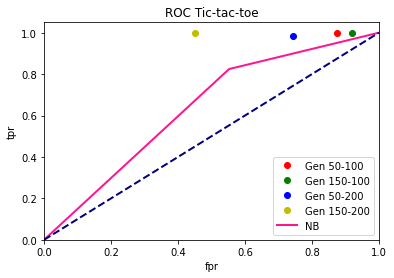

In [22]:
    plt.figure()
    lw = 2
    plt.plot(X_50_100, Y_50_100, "ro", lw=lw, label="Gen 50-100")
    plt.plot(X_150_100, Y_150_100, "go", lw=lw, label="Gen 150-100")
    plt.plot(X_50_200, Y_50_200, "bo", lw=lw, label="Gen 50-200")
    plt.plot(X_150_200, Y_150_200, "yo", lw=lw, label="Gen 150-200")
    plt.plot([0, X_nb, 1], [0, Y_nb, 1], color="deeppink", lw=lw, label="NB")
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Tic-tac-toe")
    plt.legend(loc="lower right")
    plt.show()

En este caso podemos observar como a medida que aumentamos las generaciones y el tamaño de la población nuestro algoritmo genético se distancia más de la curva dibujada por Naive-Bayes.
Se observa, además, que tiene mayor importancia el número de generaciones que el tamaño de la población, ya que el resultado de ambos ejemplos con 200 épocas están por encima de los de 100 épocas tanto con una población de 50 como de 150.
Con estos resultados comfirmamos, de nuevo, que a pesar de haber cambiado de conjunto de datos, el mejor par de datos para tamaño de población y épocas es, como era de esperar, 150-200.